# M03. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 4/19/2024
- Updated: 6/4/2025

Consider: 
- imputed starter, imputed reliever, unimputed starter, unimputed reliever variables

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"
%run "U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Data

##### Park x Weather Factors

In [3]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Park and Weather Factors.csv"))

Choose WFX
- _unadj: predicted based on weather / predicted based on batted ball <br>
- _adj: average of actual rates in similarly predicted games / predicted based on batted ball

In [4]:
wfx_type = 'adj'
for event in events_list:
    multiplier_df[f'{event}_wfx_l'] = multiplier_df[f'{event}_wfx_{wfx_type}_l'].copy()
    multiplier_df[f'{event}_wfx_r'] = multiplier_df[f'{event}_wfx_{wfx_type}_r'].copy()

##### Plate Appearances

In [5]:
complete_dataset = pd.read_csv(os.path.join(baseball_path, "Final Dataset.csv"))

##### Steamer

In [6]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

In [7]:
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')

### Clean

##### MLB Stats API

In [8]:
complete_dataset = complete_dataset[~complete_dataset[batter_inputs].isin([np.inf, -np.inf]).any(axis=1)]
complete_dataset = complete_dataset[~complete_dataset[pitcher_inputs].isin([np.inf, -np.inf]).any(axis=1)]

In [9]:
%%time
complete_dataset[batter_inputs] = scale_batter_stats.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = scale_pitcher_stats.transform(complete_dataset[pitcher_inputs])

CPU times: total: 1.64 s
Wall time: 1.64 s


##### Steamer

Clean

In [10]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

Scale

In [11]:
steamer_hitters_df2[batter_stats_fg] = scale_batter_stats_steamer.transform(steamer_hitters_df2[batter_stats_fg])

Read in pitchers

Clean

In [12]:
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

Scale

In [13]:
steamer_pitchers_df2[pitcher_stats_fg] = scale_pitcher_stats_steamer.transform(steamer_pitchers_df2[pitcher_stats_fg])

##### Merge

Format dates

In [14]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
complete_dataset['date_time_copy'] = complete_dataset['date_time'].copy()
steamer_hitters_df2['date_time'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

steamer_hitters_df2.rename(columns={'mlbamid': 'batter'}, inplace=True)
steamer_pitchers_df2.rename(columns={'mlbamid': 'pitcher'}, inplace=True)

Sort to prep for merge

In [15]:
complete_dataset.sort_values('date_time', inplace=True)
steamer_hitters_df2.sort_values('date_time', inplace=True)
steamer_pitchers_df2.sort_values('date_time', inplace=True)

Drop unnecessary columns

In [16]:
steamer_hitters_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)
steamer_pitchers_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)

Remove missing pitchers (occurs occassionally in 2014)

In [17]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['pitcher'].isna()].reset_index(drop=True)

Set data types

In [18]:
complete_dataset['batter'] = complete_dataset['batter'].astype(int).astype(str)
complete_dataset['pitcher'] = complete_dataset['pitcher'].astype(int).astype(str)
steamer_hitters_df2['batter'] = steamer_hitters_df2['batter'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['pitcher'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [19]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_hitters_df2,
    on='date_time',
    by='batter',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)
# Correct datetime (might be unnecessary, but I'm not sure which date_time it takes after the merge)
complete_merged_df['date_time'] = complete_merged_df['date_time_copy'].copy()

complete_merged_df = pd.merge_asof(
    complete_merged_df,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher',  # Group by 'batter'
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)

Merge WFX

In [20]:
complete_merged_df = pd.merge(complete_merged_df, multiplier_df, on=['gamePk', 'date', 'venue_id'], how='left')

In [21]:
multiplier_df.head()

,venue_id,gamePk,date,b1_wfx_unadj_l,b2_wfx_unadj_l,b3_wfx_unadj_l,hr_wfx_unadj_l,bb_wfx_unadj_l,hbp_wfx_unadj_l,so_wfx_unadj_l,fo_wfx_unadj_l,go_wfx_unadj_l,lo_wfx_unadj_l,po_wfx_unadj_l,b1_wfx_adj_l,b2_wfx_adj_l,b3_wfx_adj_l,hr_wfx_adj_l,bb_wfx_adj_l,hbp_wfx_adj_l,so_wfx_adj_l,fo_wfx_adj_l,go_wfx_adj_l,lo_wfx_adj_l,po_wfx_adj_l,b1_wfx_unadj_r,b2_wfx_unadj_r,b3_wfx_unadj_r,hr_wfx_unadj_r,bb_wfx_unadj_r,hbp_wfx_unadj_r,so_wfx_unadj_r,fo_wfx_unadj_r,go_wfx_unadj_r,lo_wfx_unadj_r,po_wfx_unadj_r,b1_wfx_adj_r,b2_wfx_adj_r,b3_wfx_adj_r,hr_wfx_adj_r,bb_wfx_adj_r,hbp_wfx_adj_r,so_wfx_adj_r,fo_wfx_adj_r,go_wfx_adj_r,lo_wfx_adj_r,po_wfx_adj_r,b1_pred_weather_l,b2_pred_weather_l,b3_pred_weather_l,hr_pred_weather_l,bb_pred_weather_l,hbp_pred_weather_l,so_pred_weather_l,fo_pred_weather_l,go_pred_weather_l,lo_pred_weather_l,po_pred_weather_l,b1_pred_batted_l,b2_pred_batted_l,b3_pred_batted_l,hr_pred_batted_l,bb_pred_batted_l,hbp_pred_batted_l,so_pred_batted_l,fo_pred_batted_l,go_pred_batted_l,lo_pred_batted_l,po_pred_batted_l,b1_pred_batted_mean_l,b2_pred_batted_mean_l,b3_pred_batted_mean_l,hr_pred_batted_mean_l,bb_pred_batted_mean_l,hbp_pred_batted_mean_l,so_pred_batted_mean_l,fo_pred_batted_mean_l,go_pred_batted_mean_l,lo_pred_batted_mean_l,po_pred_batted_mean_l,b1_pred_weather_r,b2_pred_weather_r,b3_pred_weather_r,hr_pred_weather_r,bb_pred_weather_r,hbp_pred_weather_r,so_pred_weather_r,fo_pred_weather_r,go_pred_weather_r,lo_pred_weather_r,po_pred_weather_r,b1_pred_batted_r,b2_pred_batted_r,b3_pred_batted_r,hr_pred_batted_r,bb_pred_batted_r,hbp_pred_batted_r,so_pred_batted_r,fo_pred_batted_r,go_pred_batted_r,lo_pred_batted_r,po_pred_batted_r,b1_pred_batted_mean_r,b2_pred_batted_mean_r,b3_pred_batted_mean_r,hr_pred_batted_mean_r,bb_pred_batted_mean_r,hbp_pred_batted_mean_r,so_pred_batted_mean_r,fo_pred_batted_mean_r,go_pred_batted_mean_r,lo_pred_batted_mean_r,po_pred_batted_mean_r,b1_l,b2_l,b3_l,hr_l,bb_l,hbp_l,so_l,fo_l,go_l,lo_l,po_l,b1_r,b2_r,b3_r,hr_r,bb_r,hbp_r,so_r,fo_r,go_r,lo_r,po_r,b1_wfx_l,b1_wfx_r,b2_wfx_l,b2_wfx_r,b3_wfx_l,b3_wfx_r,hr_wfx_l,hr_wfx_r,bb_wfx_l,bb_wfx_r,hbp_wfx_l,hbp_wfx_r,so_wfx_l,so_wfx_r,fo_wfx_l,fo_wfx_r,go_wfx_l,go_wfx_r,lo_wfx_l,lo_wfx_r,po_wfx_l,po_wfx_r
0,12,529406,20180329,1.062280,1.020507,0.848781,1.096988,0.967057,0.931697,1.009747,0.946605,0.961679,1.029211,1.068196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.048496,0.940944,0.763121,1.064729,0.975019,0.844502,1.014702,0.958782,0.977224,1.042642,1.068694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.147677,0.044267,0.003414,0.034326,0.082475,0.010277,0.228942,0.120792,0.218234,0.059451,0.050142,0.139019,0.043378,0.004023,0.031291,0.085285,0.011030,0.226732,0.127606,0.226931,0.057764,0.046941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145761,0.040816,0.003070,0.033317,0.083155,0.009315,0.230066,0.122346,0.221762,0.060227,0.050166,0.139019,0.043378,0.004023,0.031291,0.085285,0.011030,0.226732,0.127606,0.226931,0.057764,0.046941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.045455,0.045455,0.000000,0.136364,0.000000,0.090909,0.045455,0.409091,0.090909,0.136364,0.104167,0.083333,0.000000,0.020833,0.125000,0.000000,0.312500,0.062500,0.187500,0.062500,0.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4169,529407,20180329,1.056724,0.977328,0.947824,0.886396,0.960825,1.011342,0.996969,1.004928,0.964997,1.052094,1.108025,0.000000,1.047874,11.299180,0.000000,1.598916,0.000000,0.400954,0.356211,1.802714,1.573803,2.905000,1.053015,0.983332,0.843660,0.874256,0.977942,1.259712,0.999625,1.025771,0.945378,1.068183,1.046580,0.749297,1.921102,0.000000,0.665786,1.465673,0.000000,1.378278,0.489791,0.826244,1.081990,0.887639,0.146905,0.042394,0.003813,0.027737,0.081944,0.011156,0.226045,0.128234,0.218987,0.060773,0.052012,0.139019,0.043378,0.004023,0.031291,0.085285,0.011030,0.226732,0.127606,0.226931,0.057764,0.046941,0.139019,0.043378,0.004023,0.031291,0.085285,0.011030,0.226732,0.127606,0.226931,0.057764,0

##### Impute

For players with insufficient sample sizes, stats are imputed

Option 1: Steamer

First, remove from dataset if ever missing FG/Steamer stats

In [22]:
complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

In [23]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L', 'imp_b']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L', 'imp_p']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = impute_batter_stats.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = impute_pitcher_stats.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

Option 2: 0s

In [24]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Select Data

Drop early observations

In [25]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [26]:
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop observations from inactive parks

In [27]:
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

### Select Variables

Batter Inputs

In [28]:
batter_input_list = batter_inputs

Pitcher Inputs

In [29]:
pitcher_input_list = pitcher_inputs

Hand Inputs

In [30]:
hand_input_list = ['p_L', 'b_L']

Imputation Inputs

In [31]:
imp_input_list = ['imp_b', 'imp_p']

Starter Input(s)

In [32]:
starter_input_list = ['starter']

Cumulative Inning Inputs

In [33]:
cumulative_inning_input_list = [col for col in complete_merged_df.columns if col.endswith("_inning")]

In [34]:
cumulative_inning_input_list.remove('rbi_inning')

Cumulative Game Inputs

In [35]:
cumulative_game_input_list = [col for col in complete_merged_df.columns if col.endswith("_game")]

In [36]:
cumulative_game_input_list.remove('rbi_game')

Game State Inputs

In [37]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

In [38]:
game_state_input_list = ['onFirst', 'onSecond', 'onThird', 'top', 'score_diff', 'prePitcherScore', 'preBatterScore', 'winning', 'winning_big', 'times_faced']

Inning Inputs

In [39]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning'] >= 11).astype(int)

In [40]:
inning_input_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]

Out Inputs

In [41]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_pre'] == out).astype(int)

In [42]:
out_input_list = ['outs_0', 'outs_1', 'outs_2']

Venue Inputs

In [43]:
complete_merged_df['venue_id2'] = complete_merged_df['venue_id'].copy()
complete_merged_df = pd.get_dummies(complete_merged_df, columns=['venue_id2'], prefix='venue')

In [44]:
venue_input_list = [col for col in complete_merged_df.columns if col.startswith("venue_") and col != "venue_id" and col != "venue_name"]

Multiplier Inputs

In [45]:
for event in events_list:
    # Assign multiplier for their 
    complete_merged_df[f'{event}_wfx'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_wfx_l'], complete_merged_df[f'{event}_wfx_r'])

In [46]:
multiplier_input_list = [f'{event}_wfx' for event in events_list]

Imputation and starter interactions

In [47]:
# complete_merged_df['imputed_starter'] = complete_merged_df['imp_p'] * complete_merged_df['starter']
# complete_merged_df['imputed_reliever'] = complete_merged_df['imp_p'] * (complete_merged_df['starter'] == 0).astype(int)
# complete_merged_df['unimputed_starter'] = (complete_merged_df['imp_p'] == 0).astype(int) * complete_merged_df['starter']
# complete_merged_df['unimputed_reliever'] = (complete_merged_df['imp_p'] == 0).astype(int) * (complete_merged_df['starter'] == 0).astype(int)

In [48]:
# imp_starter_input_list = ['imputed_starter', 'imputed_reliever', 'unimputed_starter', 'unimputed_reliever']

Inputs

In [49]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + venue_input_list + multiplier_input_list

Outputs

In [50]:
output_list = ['is_out', 'eventsModel']

Other variables

In [51]:
additional_list = ['pa_b', 'pa_p', 'year', 'date', 'gamePk', 'atBatIndex', 'venue_id', 'batterName', 'pitcherName']

Variables to keep

In [52]:
keep_list = input_list + output_list + additional_list

### Shift

Many batter and pitcher stats are calculated at the end of the plate appearance. For prediction purposes, we need these stats coming into the plate appearance.

##### Batter Inputs

Sort

In [53]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [54]:
complete_merged_df[batter_inputs + ['ab_b', 'pa_b', 'imp_b']] = complete_merged_df.groupby(['batter', 'pitchHand'])[batter_inputs + ['ab_b', 'pa_b', 'imp_b']].shift(1)

##### Pitcher Inputs

Sort

In [55]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [56]:
complete_merged_df[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']] = complete_merged_df.groupby(['pitcher', 'batSide'])[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']].shift(1)

##### Inning Sums

Sort

In [57]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [58]:
complete_merged_df[cumulative_inning_input_list] = complete_merged_df.groupby(['gamePk', 'inning', 'pitcher'])[cumulative_inning_input_list].shift(1)
complete_merged_df[cumulative_inning_input_list] = complete_merged_df[cumulative_inning_input_list].fillna(0)

##### Game Sums

Sort

In [59]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [60]:
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df.groupby(['gamePk', 'pitcher'])[cumulative_game_input_list + ['times_faced']].shift(1)
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df[cumulative_game_input_list + ['times_faced']].fillna(0)

### Model Dataset

Create Model Dataset

In [61]:
model_dataset = complete_merged_df[keep_list]

model_dataset.dropna(subset=input_list, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

Free up memory

In [62]:
del complete_merged_df, complete_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df, batter_predictions, pitcher_predictions

In [63]:
n1 = len(input_list) + 1

### Train/Test Split

Split

In [64]:
np.random.seed(42)
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

Create masks to identify training and testing datasets

Note: to train on the entire dataset, you can simply set split = 0 for the entire dataset

In [65]:
training_mask = (model_dataset['split'] == 0)

### Model 1. All - Unadjusted

In [66]:
all_stat_list = []

##### Settings

In [67]:
layers = (256, 128, 64)
activation = 'relu'
max_iter = 100
alpha = 0.00001
learning_rate_init = 0.0001 
batch_size='auto'
batch_size=8192
random_state = random.randint(10000,99900)
dropout = 0.1 # Need to switch to MLPDropout to use
early_stopping = True
tol=0.000001
n_iter_no_change=5
num_models = 40
num_classifiers = 1

quantiles = 10

len(input_list)

194

Remove venue dummies

In [68]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list #+ multiplier_input_list
len(input_list)

153

predict_all_25612864_79593_20250627.sav
Single Classifier
Iteration 1, loss = 2.14501293
Validation score: 0.238399
Iteration 2, loss = 2.05975506
Validation score: 0.244729
Iteration 3, loss = 2.04871456
Validation score: 0.247639
Iteration 4, loss = 2.04397239
Validation score: 0.252769
Iteration 5, loss = 2.04046017
Validation score: 0.257006
Iteration 6, loss = 2.03732011
Validation score: 0.259993
Iteration 7, loss = 2.03423510
Validation score: 0.264255
Iteration 8, loss = 2.03121192
Validation score: 0.264817
Iteration 9, loss = 2.02867520
Validation score: 0.266655
Iteration 10, loss = 2.02649009
Validation score: 0.266961
Iteration 11, loss = 2.02485451
Validation score: 0.268416
Iteration 12, loss = 2.02332271
Validation score: 0.267574
Iteration 13, loss = 2.02236385
Validation score: 0.268110
Iteration 14, loss = 2.02118091
Validation score: 0.268748
Iteration 15, loss = 2.02013667
Validation score: 0.269029
Iteration 16, loss = 2.01927568
Validation score: 0.269973
Iterati

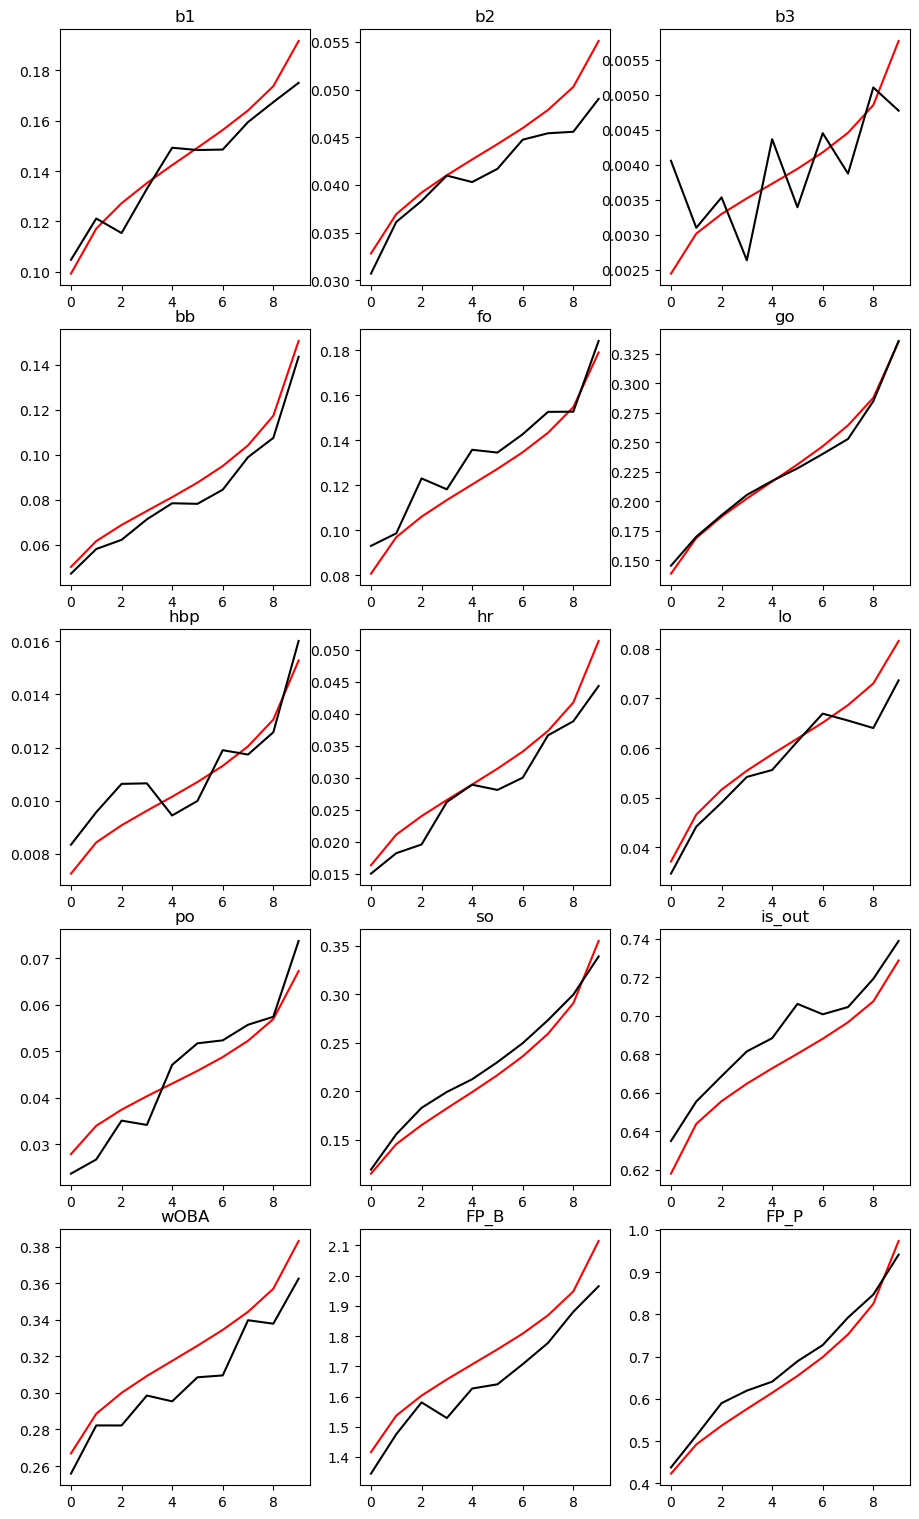

predict_all_25612864_79594_20250627.sav
Single Classifier
Iteration 1, loss = 2.15274870
Validation score: 0.230895
Iteration 2, loss = 2.05775732
Validation score: 0.238144
Iteration 3, loss = 2.04878698
Validation score: 0.240339
Iteration 4, loss = 2.04461231
Validation score: 0.243530
Iteration 5, loss = 2.04163601
Validation score: 0.247945
Iteration 6, loss = 2.03905203
Validation score: 0.250089
Iteration 7, loss = 2.03638792
Validation score: 0.254582
Iteration 8, loss = 2.03355404
Validation score: 0.256853
Iteration 9, loss = 2.03080614
Validation score: 0.260682
Iteration 10, loss = 2.02833899
Validation score: 0.263081
Iteration 11, loss = 2.02622627
Validation score: 0.264485
Iteration 12, loss = 2.02450560
Validation score: 0.263745
Iteration 13, loss = 2.02295233
Validation score: 0.265379
Iteration 14, loss = 2.02188577
Validation score: 0.265455
Iteration 15, loss = 2.02081212
Validation score: 0.265991
Iteration 16, loss = 2.02005387
Validation score: 0.264383
Iterati

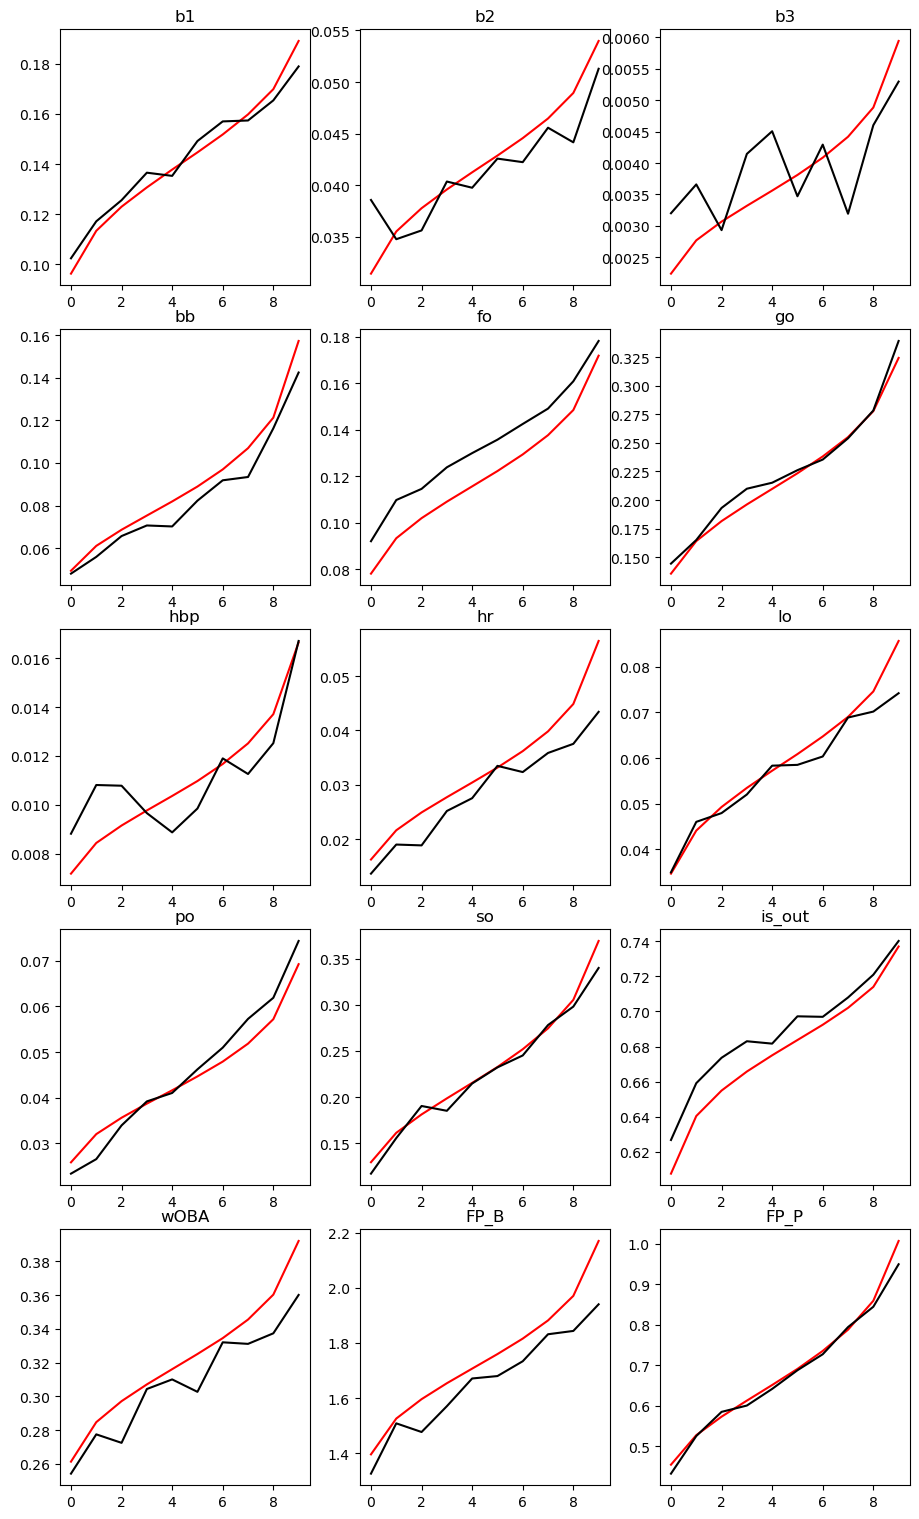

predict_all_25612864_79595_20250627.sav
Single Classifier
Iteration 1, loss = 2.18539087
Validation score: 0.235132
Iteration 2, loss = 2.06240779
Validation score: 0.242228
Iteration 3, loss = 2.04960480
Validation score: 0.247103
Iteration 4, loss = 2.04462162
Validation score: 0.251289
Iteration 5, loss = 2.04119354
Validation score: 0.254862
Iteration 6, loss = 2.03825519
Validation score: 0.257185
Iteration 7, loss = 2.03535407
Validation score: 0.258334
Iteration 8, loss = 2.03252149
Validation score: 0.260478
Iteration 9, loss = 2.02995393
Validation score: 0.260861
Iteration 10, loss = 2.02765231
Validation score: 0.263183
Iteration 11, loss = 2.02569369
Validation score: 0.261448
Iteration 12, loss = 2.02402820
Validation score: 0.262954
Iteration 13, loss = 2.02268918
Validation score: 0.263949
Iteration 14, loss = 2.02148770
Validation score: 0.262979
Iteration 15, loss = 2.02054033
Validation score: 0.264358
Iteration 16, loss = 2.01951617
Validation score: 0.264791
Iterati

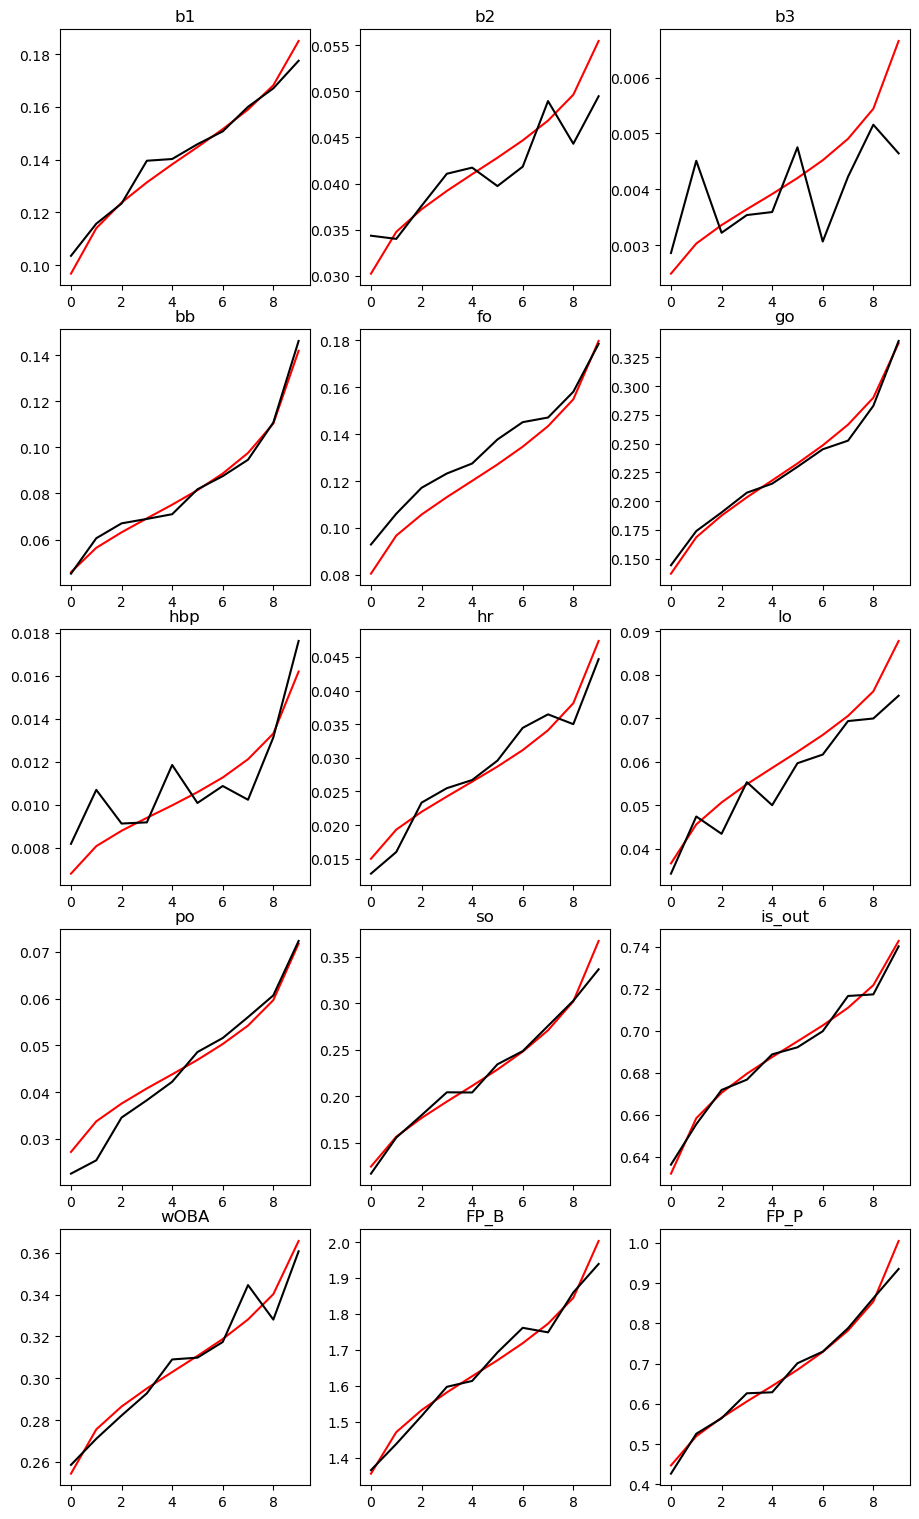

predict_all_25612864_79596_20250627.sav
Single Classifier
Iteration 1, loss = 2.21164821
Validation score: 0.239292
Iteration 2, loss = 2.05936396
Validation score: 0.245189
Iteration 3, loss = 2.04818366
Validation score: 0.249145
Iteration 4, loss = 2.04408301
Validation score: 0.251927
Iteration 5, loss = 2.04132286
Validation score: 0.255526



KeyboardInterrupt



In [70]:
%%time
for i in range(num_models):
    # Set filename
    all_filename = f"predict_all_{''.join(str(x) for x in layers)}_{random_state+i}_{todaysdate}.sav"
    print(all_filename)

    # Determine if voting
    if num_classifiers > 1:
        print("Voting Classifier")
        # Build list of MLP classifiers with varied random_state
        estimators = []
        for j in range(num_classifiers):
            clf = MLPClassifier(
                hidden_layer_sizes=layers,
                activation=activation,
                verbose=True,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                early_stopping=early_stopping,
                random_state=random_state + i + j * 100,
                max_iter=max_iter,
                tol=tol,
                n_iter_no_change=n_iter_no_change,
                batch_size=batch_size
            )
            estimators.append((f"mlp_{j}", clf))
        
        # Combine into a soft voting classifier
        predict_all = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

    else:
        print("Single Classifier")
        # Create Model
        predict_all = MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, 
                                    learning_rate_init=learning_rate_init, early_stopping=early_stopping, random_state=random_state+i, max_iter=max_iter,
                                    tol=tol, n_iter_no_change=n_iter_no_change,
                                    batch_size=batch_size, validation_fraction=0.05)

    # Fit
    predict_all.fit(model_dataset[training_mask][input_list], model_dataset[training_mask][['eventsModel']].values.ravel())

    # Save model
    pickle.dump(predict_all, open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'wb'))
    
    # Predict all types
    all_outputs = list(predict_all.classes_)
    all_outputs_pred = [x + "_pred" for x in all_outputs]
    
    model_dataset.loc[~training_mask, all_outputs_pred] = predict_all.predict_proba(model_dataset[~training_mask][input_list])


    ### Constructed Stats
    # FP - Outs
    model_dataset.loc[~training_mask, 'FP_P_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "fo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "go").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "po").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "lo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "so").astype(int) * 2.4866)

    model_dataset.loc[~training_mask, 'FP_P_pred'] = (model_dataset[~training_mask]['fo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['go_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['po_pred'] * 0.2534 + 
                                                      model_dataset[~training_mask]['lo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['so_pred'] * 2.4866)

    # FP - Safe
    model_dataset.loc[~training_mask, 'FP_B_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  *  4.3665 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  *  6.8271 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 10.8503 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 15.2611 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  *  2.8725 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) *  2.9639)

    model_dataset.loc[~training_mask, 'FP_B_pred'] = (model_dataset[~training_mask]['b1_pred']  *  4.3665 +
                                                      model_dataset[~training_mask]['b2_pred']  *  6.8271 +
                                                      model_dataset[~training_mask]['b3_pred']  * 10.8503 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 15.2611 +
                                                      model_dataset[~training_mask]['bb_pred']  *  2.8725 +
                                                      model_dataset[~training_mask]['hbp_pred'] *  2.9639)

    # wOBA (roughly)
    model_dataset.loc[~training_mask, 'wOBA_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  * 0.882 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  * 1.254 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 1.590 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 2.050 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  * 0.689 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) * 0.720)

    model_dataset.loc[~training_mask, 'wOBA_pred'] = (model_dataset[~training_mask]['b1_pred']  * 0.882 +
                                                      model_dataset[~training_mask]['b2_pred']  * 1.254 +
                                                      model_dataset[~training_mask]['b3_pred']  * 1.590 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 2.050 +
                                                      model_dataset[~training_mask]['bb_pred']  * 0.689 +
                                                      model_dataset[~training_mask]['hbp_pred'] * 0.720)
    
    # Out
    model_dataset['is_out_act'] = model_dataset['is_out'].copy()
    
    model_dataset.loc[~training_mask, 'is_out_pred'] = (model_dataset[~training_mask]['fo_pred'] +
                                                        model_dataset[~training_mask]['go_pred'] +
                                                        model_dataset[~training_mask]['po_pred'] + 
                                                        model_dataset[~training_mask]['lo_pred'] +
                                                        model_dataset[~training_mask]['so_pred'])


    # "TESTING"
    model_dataset['so_act'] = (model_dataset['eventsModel'] == "so").astype(int)
    print(model_dataset[~training_mask].groupby(['imp_p', 'starter'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())

    print(model_dataset[~training_mask].groupby('venue_id')[['FP_B_pred', 'FP_B_act', 'FP_P_pred', 'FP_P_act']].mean())

    model_dataset['hr_act'] = (model_dataset['eventsModel'] == "hr").astype(int)
    model_dataset['hr_wfx_decile'] = pd.qcut(model_dataset['hr_wfx'], q=10, labels=False) + 1
    print(model_dataset[~training_mask].groupby('hr_wfx_decile')[['hr_pred', 'hr_act']].mean())
    
    
    # Quantiles
    year = 2024
    venue = 19
    
    for var in all_outputs:
        # Create actual outcome column
        model_dataset.loc[~training_mask, f'{var}_act'] = (model_dataset.loc[~training_mask, 'eventsModel'] == var).astype(int)
        
        # Create deciles
        model_dataset.loc[~training_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    for var in ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        # Create deciles
        model_dataset.loc[~training_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

    # All
    all_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    # Year
    recent_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    # DataFrame
    all_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    all_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    all_stat_df['File'] = all_filename
    all_stat_df['Layers'] = str(layers)
    all_stat_df['Models'] = num_models
    all_stat_df['State'] = random_state+i
    all_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(all_stat_df[['Year', 'Output', 'Actual', 'Predicted', 'Multiplier', 'Std. Dev', 'MSE']])
    
    all_stat_list.append(all_stat_df)
    
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")

    # Create figures
    rows, columns = 5, 3
    fig, axs = plt.subplots(rows, columns, figsize=(9, 15))
    
    # Ensure that the number of plots doesn't exceed available subplots
    total_plots = rows * columns
    output_vars = all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']
    
    # Limit the number of plots to the available subplots
    output_vars = output_vars[:total_plots]
    
    for i, var in enumerate(output_vars):
        row = i // columns  # Calculate the row index based on the iteration
        col = i % columns   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()

In [ ]:
all_stat_df = pd.concat(all_stat_list)
all_stat_df = all_stat_df.reset_index(drop=True)

In [ ]:
subset = all_stat_df.query('Year == "2024"').query('Output == "wOBA"').query('1.01 > Multiplier > 0.99').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

##### 

### Predict

In [71]:
all_filename = "predict_all_25612864_79595_20250627.sav"

predict_all = pickle.load(open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'rb'))

In [72]:
# Predict all types
all_outputs = list(predict_all.classes_)
all_outputs_pred = [x + "_pred1" for x in all_outputs]

model_dataset[all_outputs_pred] = predict_all.predict_proba(model_dataset[input_list])

In [73]:
model_dataset.tail()

,b1_b,b2_b,b3_b,hr_b,bb_b,hbp_b,so_b,fo_b,go_b,lo_b,po_b,estimated_woba_using_speedangle_b,to_left_b,to_middle_b,to_right_b,hard_hit_b,barrel_b,iso_b,slg_b,obp_b,woba_b,totalDistance_b,launchSpeed_b,b1_b_long,b2_b_long,b3_b_long,hr_b_long,bb_b_long,hbp_b_long,so_b_long,fo_b_long,go_b_long,lo_b_long,po_b_long,estimated_woba_using_speedangle_b_long,to_left_b_long,to_middle_b_long,to_right_b_long,hard_hit_b_long,barrel_b_long,iso_b_long,slg_b_long,obp_b_long,woba_b_long,totalDistance_b_long,launchSpeed_b_long,b1_p,b2_p,b3_p,hr_p,bb_p,hbp_p,so_p,fo_p,go_p,lo_p,po_p,estimated_woba_using_speedangle_p,to_left_p,to_middle_p,to_right_p,hard_hit_p,barrel_p,iso_p,slg_p,obp_p,woba_p,maxSpeed_p,maxSpin_p,b1_p_long,b2_p_long,b3_p_long,hr_p_long,bb_p_long,hbp_p_long,so_p_long,fo_p_long,go_p_long,lo_p_long,po_p_long,estimated_woba_using_speedangle_p_long,to_left_p_long,to_middle_p_long,to_right_p_long,hard_hit_p_long,barrel_p_long,iso_p_long,slg_p_long,obp_p_long,woba_p_long,maxSpeed_p_long,maxSpin_p_long,p_L,b_L,imp_b,imp_p,starter,b1_inning,b2_inning,b3_inning,hr_inning,bb_inning,hbp_inning,so_inning,fo_inning,go_inning,lo_inning,po_inning,h_inning,tb_inning,reached_inning,faced_inning,outs_pa_inning,b1_game,b2_game,b3_game,hr_game,bb_game,hbp_game,so_game,fo_game,go_game,lo_game,po_game,h_game,tb_game,reached_game,faced_game,outs_pa_game,onFirst,onSecond,onThird,top,score_diff,prePitcherScore,preBatterScore,winning,winning_big,times_faced,inning_1,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9,inning_10,inning_11,outs_0,outs_1,outs_2,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_14,venue_15,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2602,venue_2680,venue_2681,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5325,b1_wfx,b2_wfx,b3_wfx,hr_wfx,bb_wfx,hbp_wfx,so_wfx,fo_wfx,go_wfx,lo_wfx,po_wfx,is_out,eventsModel,pa_b,pa_p,year,date,gamePk,atBatIndex,venue_id,batterName,pitcherName,split,b1_pred,b2_pred,b3_pred,bb_pred,fo_pred,go_pred,hbp_pred,hr_pred,lo_pred,po_pred,so_pred,FP_P_act,FP_P_pred,FP_B_act,FP_B_pred,wOBA_act,wOBA_pred,is_out_act,is_out_pred,so_act,hr_act,hr_wfx_decile,b1_act,b1_decile,b2_act,b2_decile,b3_act,b3_decile,bb_act,bb_decile,fo_act,fo_decile,go_act,go_decile,hbp_act,hbp_decile,hr_decile,lo_act,lo_decile,po_act,po_decile,so_decile,is_out_decile,wOBA_decile,FP_B_decile,FP_P_decile,b1_pred1,b2_pred1,b3_pred1,bb_pred1,fo_pred1,go_pred1,hbp_pred1,hr_pred1,lo_pred1,po_pred1,so_pred1
1175070,0.166865,0.028561,0.019362,0.072835,0.040000,0.040000,0.180000,0.047025,0.381281,0.050398,0.020327,0.178384,0.240000,0.320000,0.180000,0.300000,0.080000,0.088440,0.136681,0.337320,0.184362,0.805941,0.870627,0.136134,0.070518,0.042479,0.049927,0.056667,0.016667,0.226667,0.115558,0.265307,0.067638,0.029964,0.164457,0.240000,0.300000,0.160000,0.323333,0.073333,0.076743,0.122692,0.313276,0.168073,0.849505,0.909683,0.165315,0.035813,0.028390,0.024142,0.040000,0.000000,0.220000,0.101906,0.357083,0.049063,0.034845,0.134001,0.180000,0.360000,0.200000,0.320000,0.040000,0.036863,0.083422,0.253445,0.124826,0.506166,0.707953,0.172835,0.057890,0.039756,0.019049,0.030000,0.006667,0.263333,0.113345,0.264233,0.075861,0.033763,0.147403,0.170000,0.310000,0.220000,0.263333,0.030000,0.038241,0.089603,0.270619,0.133246,0.506166,0.707953,False,False,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,1,-3.000000,3.000000,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1.073043,0.903937,0.679711,0

### Model #2. WFX Adjustments

In [74]:
all_adjusted_input_list = [col for col in model_dataset if col.endswith("pred1")] + multiplier_input_list

len(all_adjusted_input_list)

22

In [114]:
### Testing
all_adjusted_input_list = [col for col in model_dataset if col.endswith("pred1")] + multiplier_input_list


all_adjusted_input_list = []



for event in events_list:
    model_dataset[f'{event}_int'] = model_dataset[f'{event}_pred1'] * model_dataset[f'{event}_wfx']
    all_adjusted_input_list.append(f'{event}_int')

In [115]:
model_dataset[all_adjusted_input_list].tail()

,b1_int,b2_int,b3_int,hr_int,bb_int,hbp_int,so_int,fo_int,go_int,lo_int,po_int
1175070,0.181043,0.036761,0.003170,0.013809,0.038522,0.010446,0.210576,0.080032,0.339350,0.064057,0.034899
1175071,0.199734,0.040359,0.002523,0.015494,0.046010,0.011074,0.170882,0.102566,0.326031,0.058925,0.041208
1175072,0.172460,0.035025,0.016673,0.013736,0.072002,0.007126,0.133881,0.138063,0.312690,0.059430,0.037695
1175073,0.134225,0.039314,0.002156,0.022691,0.083491,0.011994,0.240472,0.117901,0.243771,0.052812,0.045190
1175074,0.111340,0.035253,0.002181,0.019407,0.091065,0.011457,0.244488,0.122438,0.228178,0.070694,0.057953


In [122]:
all_adjusted_input_list

['b1_int',
 'b2_int',
 'b3_int',
 'hr_int',
 'bb_int',
 'hbp_int',
 'so_int',
 'fo_int',
 'go_int',
 'lo_int',
 'po_int']

In [161]:
all_adjusted_stat_list = []

In [162]:
layers = (32,)
activation = 'relu'
max_iter = 100
alpha = 0.001
learning_rate_init = 0.01 
# batch_size='auto'
batch_size=1000
random_state = random.randint(10000,99900)
random_state = 10
dropout = 0.1 # Need to switch to MLPDropout to use
early_stopping = True
tol=0.000001
n_iter_no_change=10
num_models = 40
num_classifiers = 1

quantiles = 10


len(all_adjusted_input_list)

11

predict_all_adjusted_32_10_20250627.sav
Single Classifier
predict_all_adjusted_32_10_20250627.sav
Iteration 1, loss = 2.04619759
Validation score: 0.269156
Iteration 2, loss = 2.02216434
Validation score: 0.269896
Iteration 3, loss = 2.02146282
Validation score: 0.268416
Iteration 4, loss = 2.02021071
Validation score: 0.270126
Iteration 5, loss = 2.01899540
Validation score: 0.268901
Iteration 6, loss = 2.01843896
Validation score: 0.270305
Iteration 7, loss = 2.01817268
Validation score: 0.269590
Iteration 8, loss = 2.01791874
Validation score: 0.270764
Iteration 9, loss = 2.01779049
Validation score: 0.269794
Iteration 10, loss = 2.01778533
Validation score: 0.269794
Iteration 11, loss = 2.01771373
Validation score: 0.270152
Iteration 12, loss = 2.01764503
Validation score: 0.269335
Iteration 13, loss = 2.01766387
Validation score: 0.269845
Iteration 14, loss = 2.01757022
Validation score: 0.269590
Iteration 15, loss = 2.01762829
Validation score: 0.270279
Iteration 16, loss = 2.017

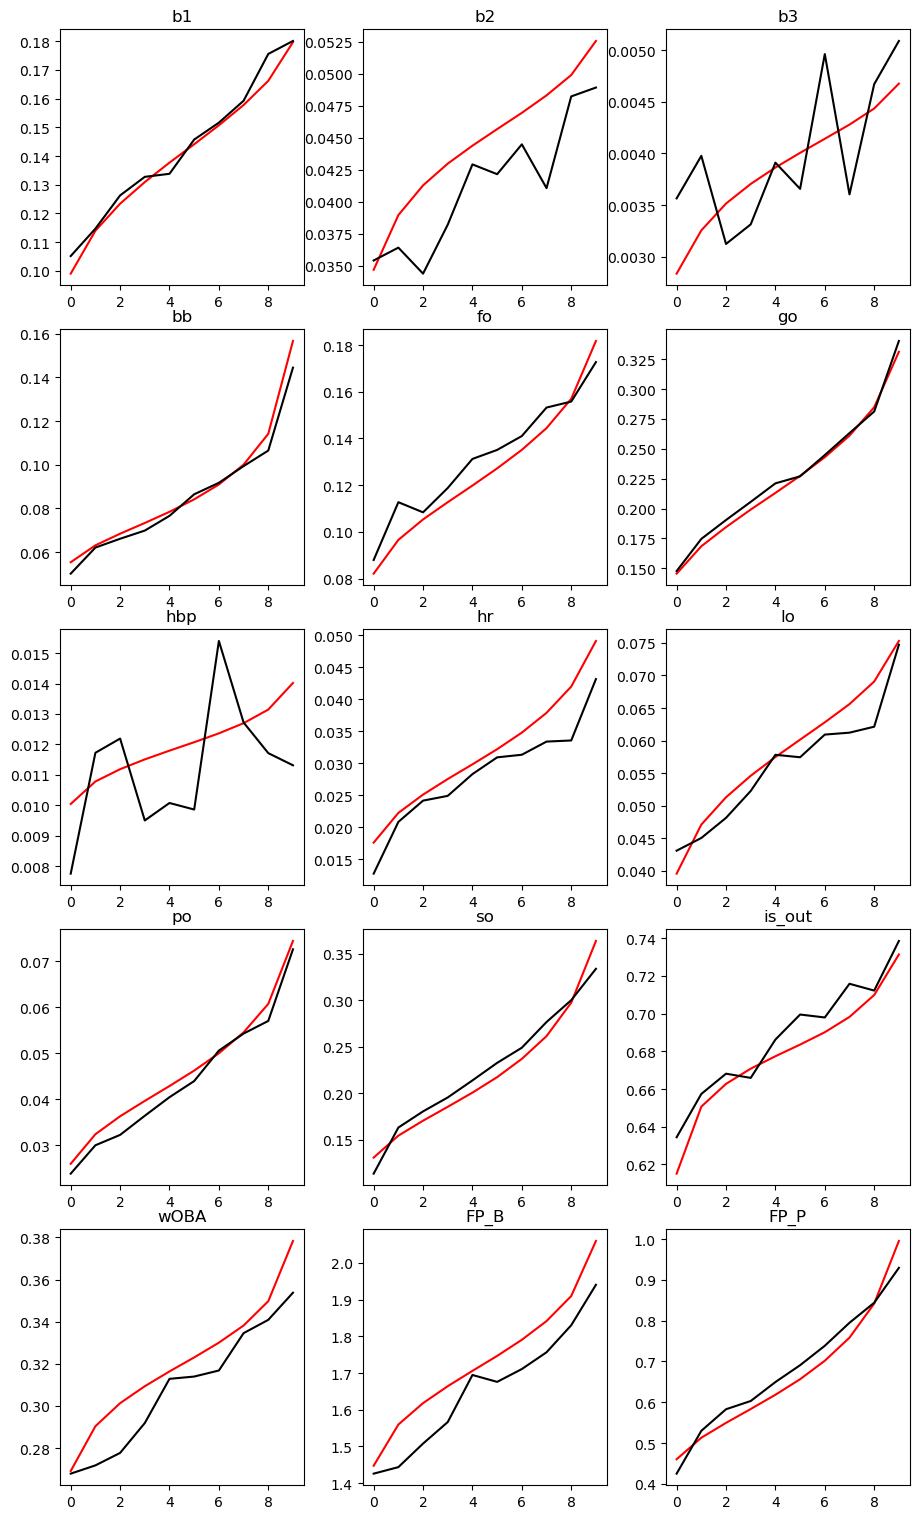

predict_all_adjusted_32_11_20250627.sav
Single Classifier
predict_all_adjusted_32_20_20250627.sav
Iteration 1, loss = 2.03257150
Validation score: 0.268620
Iteration 2, loss = 2.01764651
Validation score: 0.266655
Iteration 3, loss = 2.01692490
Validation score: 0.269029
Iteration 4, loss = 2.01629945
Validation score: 0.269156
Iteration 5, loss = 2.01582593
Validation score: 0.268008
Iteration 6, loss = 2.01552109
Validation score: 0.268952
Iteration 7, loss = 2.01529004
Validation score: 0.267752
Iteration 8, loss = 2.01527009
Validation score: 0.267114
Iteration 9, loss = 2.01504972
Validation score: 0.267114
Iteration 10, loss = 2.01499066
Validation score: 0.268314
Iteration 11, loss = 2.01515488
Validation score: 0.268569
Iteration 12, loss = 2.01500609
Validation score: 0.267574
Iteration 13, loss = 2.01507912
Validation score: 0.267369
Iteration 14, loss = 2.01492579
Validation score: 0.269131
Iteration 15, loss = 2.01487775
Validation score: 0.267982
Validation score did not i

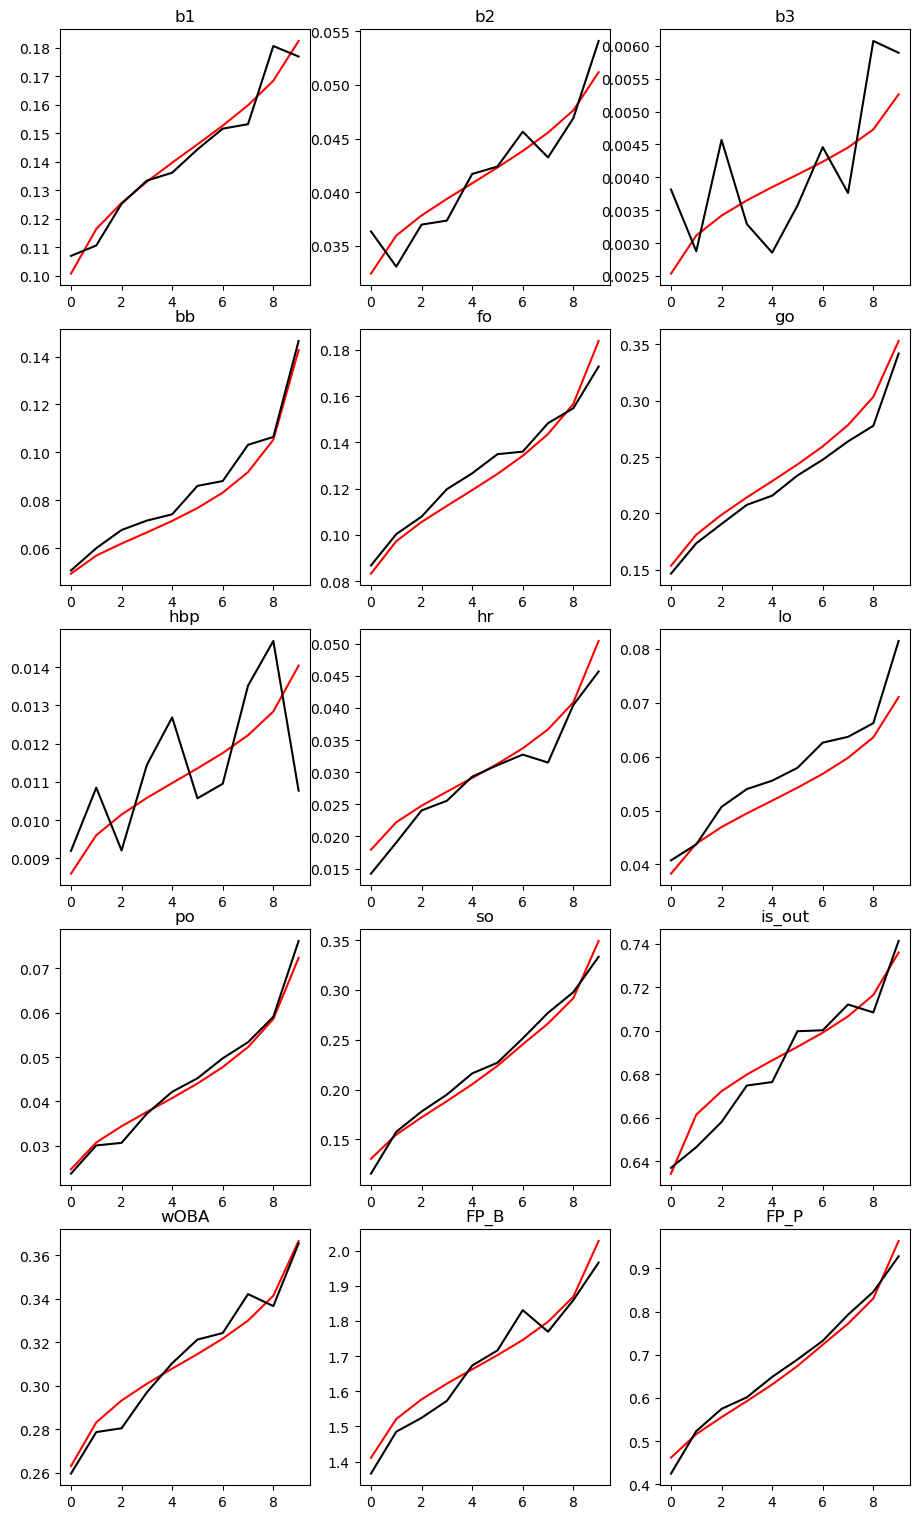

predict_all_adjusted_32_12_20250627.sav
Single Classifier
predict_all_adjusted_32_30_20250627.sav
Iteration 1, loss = 2.03020817
Validation score: 0.270279
Iteration 2, loss = 2.01749044
Validation score: 0.270917
Iteration 3, loss = 2.01701448
Validation score: 0.271147
Iteration 4, loss = 2.01639627
Validation score: 0.271504
Iteration 5, loss = 2.01608258
Validation score: 0.271122
Iteration 6, loss = 2.01579369
Validation score: 0.271760
Iteration 7, loss = 2.01565696
Validation score: 0.270356
Iteration 8, loss = 2.01550873
Validation score: 0.272040
Iteration 9, loss = 2.01546444
Validation score: 0.272730
Iteration 10, loss = 2.01516256
Validation score: 0.272423
Iteration 11, loss = 2.01518366
Validation score: 0.271096
Iteration 12, loss = 2.01510757
Validation score: 0.271224
Iteration 13, loss = 2.01523514
Validation score: 0.271275
Iteration 14, loss = 2.01503673
Validation score: 0.271300
Iteration 15, loss = 2.01498147
Validation score: 0.271658
Iteration 16, loss = 2.014

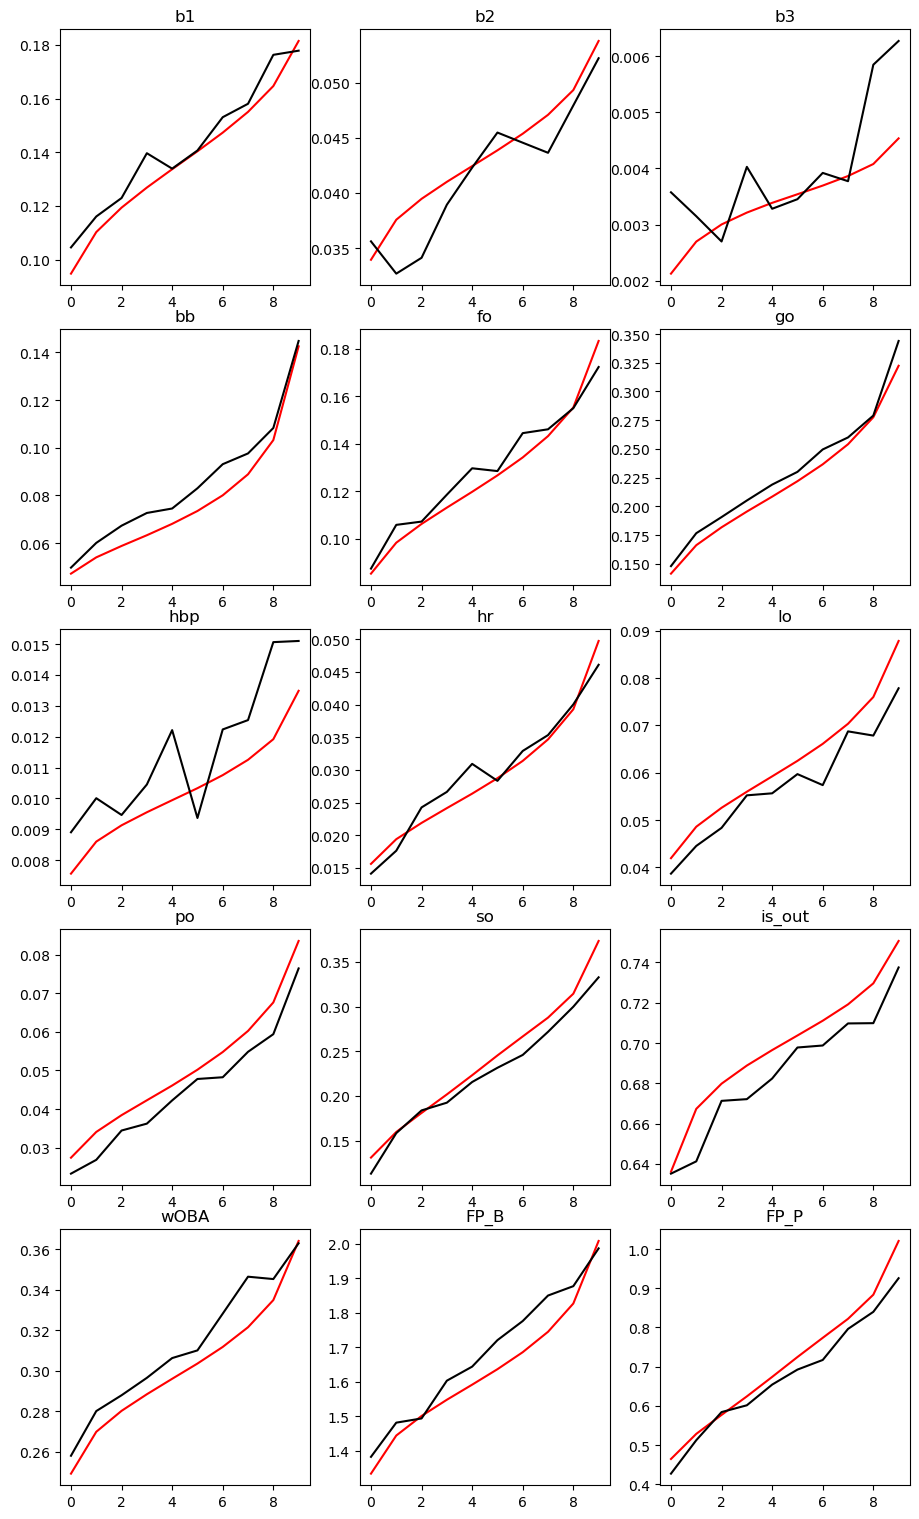

predict_all_adjusted_32_13_20250627.sav
Single Classifier
predict_all_adjusted_32_40_20250627.sav
Iteration 1, loss = 2.02423888
Validation score: 0.274210
Iteration 2, loss = 2.01739833
Validation score: 0.274644
Iteration 3, loss = 2.01648526
Validation score: 0.275231
Iteration 4, loss = 2.01607354
Validation score: 0.275869
Iteration 5, loss = 2.01582241
Validation score: 0.275384
Iteration 6, loss = 2.01553003
Validation score: 0.274414
Iteration 7, loss = 2.01541603
Validation score: 0.274108
Iteration 8, loss = 2.01529608
Validation score: 0.275308
Iteration 9, loss = 2.01522546
Validation score: 0.274848
Iteration 10, loss = 2.01518028
Validation score: 0.276150
Iteration 11, loss = 2.01502825
Validation score: 0.275282
Iteration 12, loss = 2.01508824
Validation score: 0.275588
Iteration 13, loss = 2.01510287
Validation score: 0.275282
Iteration 14, loss = 2.01495954
Validation score: 0.275665
Iteration 15, loss = 2.01508648
Validation score: 0.275027
Iteration 16, loss = 2.014

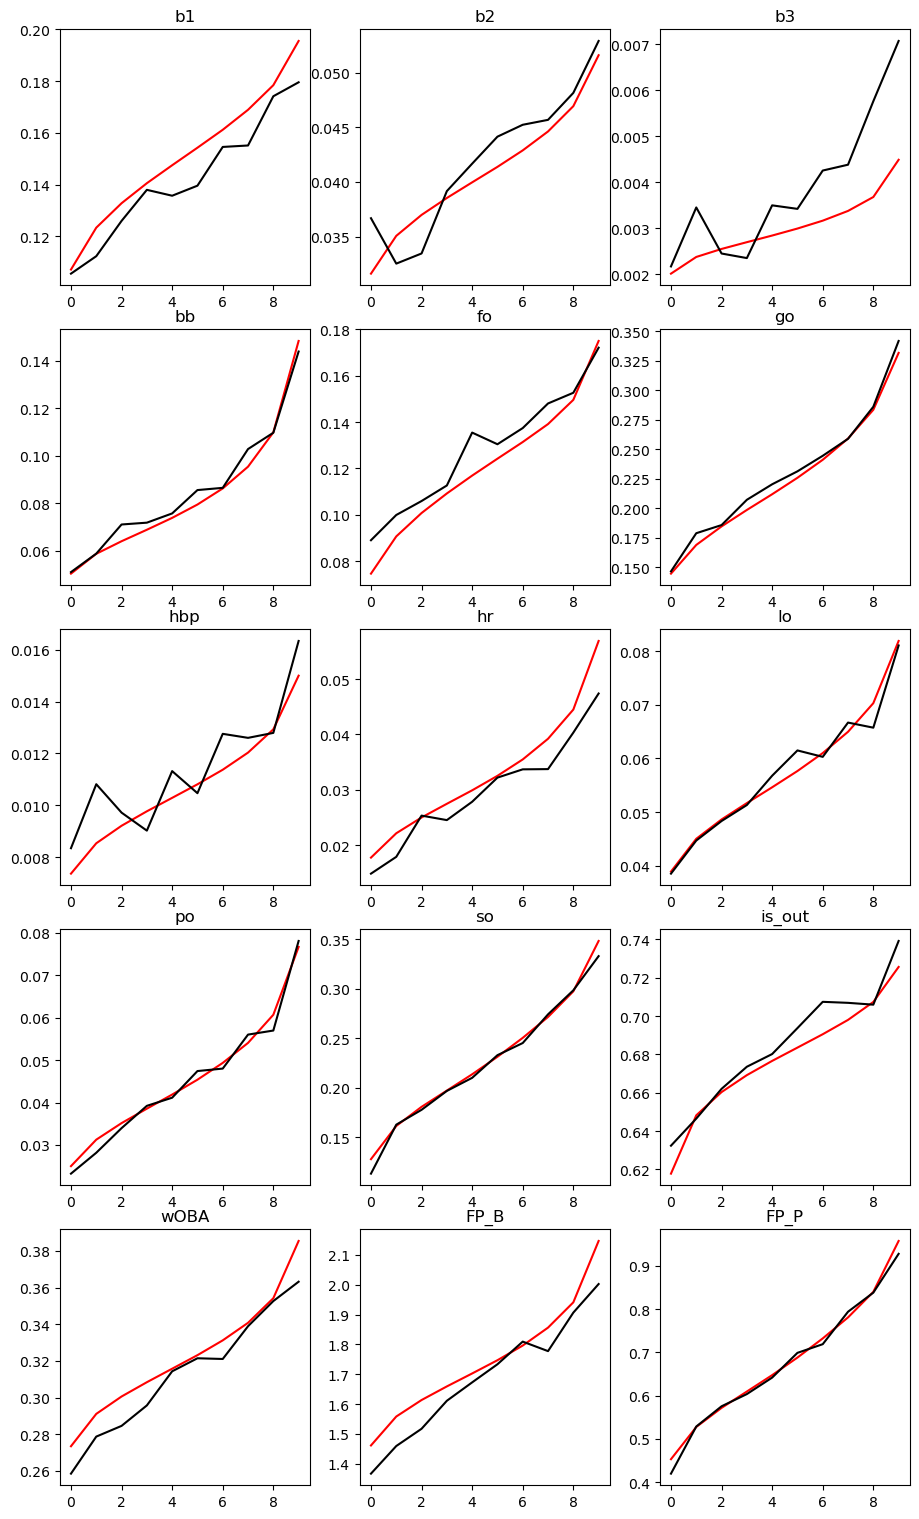

predict_all_adjusted_32_14_20250627.sav
Single Classifier
predict_all_adjusted_32_50_20250627.sav
Iteration 1, loss = 2.02616808
Validation score: 0.267012
Iteration 2, loss = 2.01723775
Validation score: 0.266272
Iteration 3, loss = 2.01635317
Validation score: 0.266757
Iteration 4, loss = 2.01583782
Validation score: 0.266068
Iteration 5, loss = 2.01530515
Validation score: 0.266272
Iteration 6, loss = 2.01532565
Validation score: 0.265787
Iteration 7, loss = 2.01502389
Validation score: 0.266859
Iteration 8, loss = 2.01506930
Validation score: 0.262750
Iteration 9, loss = 2.01484198
Validation score: 0.267318
Iteration 10, loss = 2.01486264
Validation score: 0.266910
Iteration 11, loss = 2.01463990
Validation score: 0.266757
Iteration 12, loss = 2.01463215
Validation score: 0.265455
Iteration 13, loss = 2.01457539
Validation score: 0.265889
Iteration 14, loss = 2.01456807
Validation score: 0.265863
Iteration 15, loss = 2.01461083
Validation score: 0.267497
Iteration 16, loss = 2.014

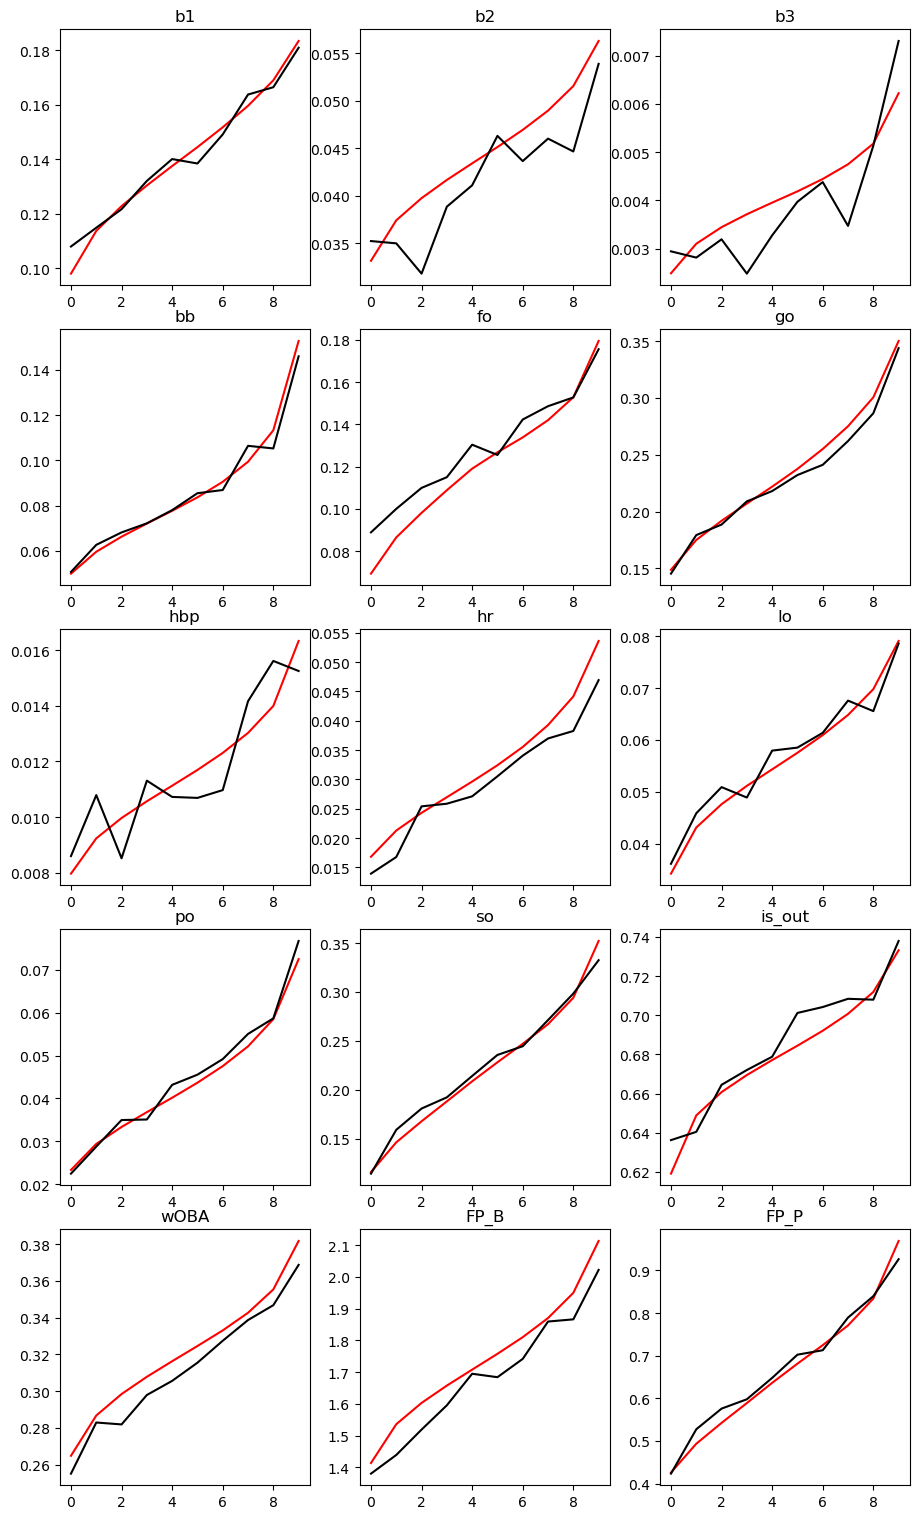

predict_all_adjusted_32_15_20250627.sav
Single Classifier
predict_all_adjusted_32_60_20250627.sav
Iteration 1, loss = 2.02485628
Validation score: 0.271964
Iteration 2, loss = 2.01757529
Validation score: 0.269820
Iteration 3, loss = 2.01667924
Validation score: 0.271198
Iteration 4, loss = 2.01608282
Validation score: 0.271938
Iteration 5, loss = 2.01579233
Validation score: 0.271862
Iteration 6, loss = 2.01558100
Validation score: 0.270713
Iteration 7, loss = 2.01534059
Validation score: 0.270892
Iteration 8, loss = 2.01549203
Validation score: 0.272347
Iteration 9, loss = 2.01532497
Validation score: 0.271453
Iteration 10, loss = 2.01502369
Validation score: 0.272040
Iteration 11, loss = 2.01504167
Validation score: 0.272627
Iteration 12, loss = 2.01493364
Validation score: 0.271862
Iteration 13, loss = 2.01490878
Validation score: 0.272040
Iteration 14, loss = 2.01486067
Validation score: 0.271964
Iteration 15, loss = 2.01484183
Validation score: 0.272245
Iteration 16, loss = 2.014

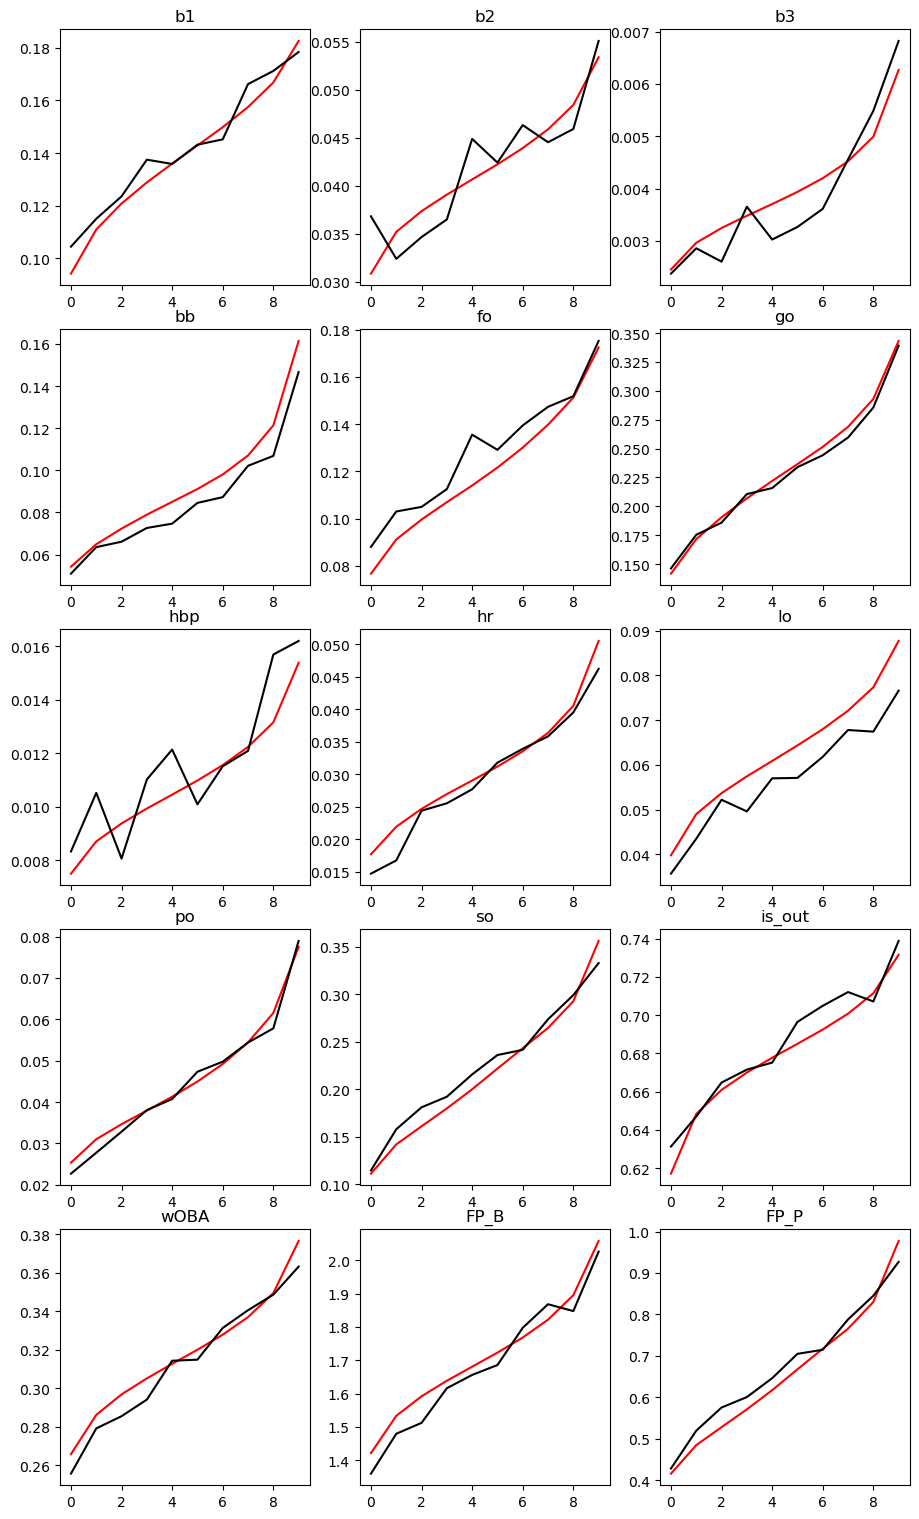

predict_all_adjusted_32_16_20250627.sav
Single Classifier
predict_all_adjusted_32_70_20250627.sav
Iteration 1, loss = 2.02594178
Validation score: 0.270177
Iteration 2, loss = 2.01730802
Validation score: 0.269769
Iteration 3, loss = 2.01635678
Validation score: 0.269386
Iteration 4, loss = 2.01580094
Validation score: 0.269386
Iteration 5, loss = 2.01537479
Validation score: 0.269309
Iteration 6, loss = 2.01520403
Validation score: 0.270050
Iteration 7, loss = 2.01502555
Validation score: 0.269565
Iteration 8, loss = 2.01472325
Validation score: 0.270101
Iteration 9, loss = 2.01466576
Validation score: 0.270534
Iteration 10, loss = 2.01471880
Validation score: 0.270662
Iteration 11, loss = 2.01471776
Validation score: 0.269845
Iteration 12, loss = 2.01461650
Validation score: 0.270509
Iteration 13, loss = 2.01448733
Validation score: 0.270203
Iteration 14, loss = 2.01442335
Validation score: 0.269769
Iteration 15, loss = 2.01439524
Validation score: 0.269871
Iteration 16, loss = 2.014

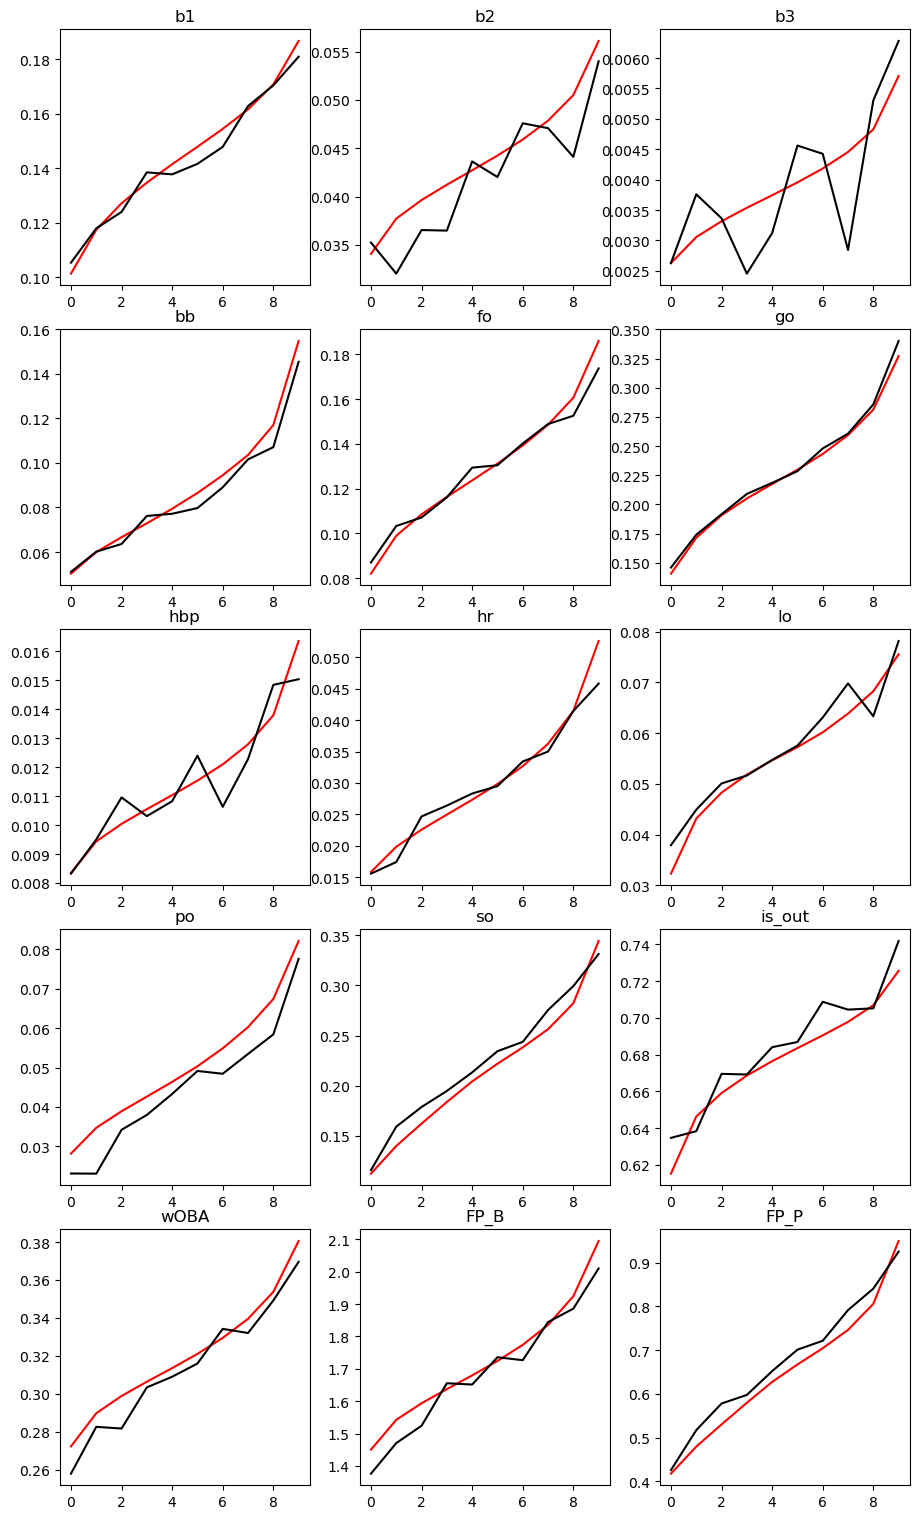

predict_all_adjusted_32_17_20250627.sav
Single Classifier
predict_all_adjusted_32_80_20250627.sav
Iteration 1, loss = 2.02628666
Validation score: 0.266068
Iteration 2, loss = 2.01798926
Validation score: 0.268875
Iteration 3, loss = 2.01689992
Validation score: 0.268467
Iteration 4, loss = 2.01607721
Validation score: 0.269258
Iteration 5, loss = 2.01580494
Validation score: 0.268875
Iteration 6, loss = 2.01569219
Validation score: 0.268033
Iteration 7, loss = 2.01522953
Validation score: 0.268467
Iteration 8, loss = 2.01514148
Validation score: 0.268850
Iteration 9, loss = 2.01507430
Validation score: 0.268212
Iteration 10, loss = 2.01495754
Validation score: 0.268671
Iteration 11, loss = 2.01497427
Validation score: 0.268977
Iteration 12, loss = 2.01490007
Validation score: 0.269284
Iteration 13, loss = 2.01483670
Validation score: 0.268748
Iteration 14, loss = 2.01476976
Validation score: 0.267778
Iteration 15, loss = 2.01495692
Validation score: 0.269207
Iteration 16, loss = 2.014


KeyboardInterrupt



In [163]:
%%time
for i in range(num_models):
    # Set filename
    all_adjusted_filename = f"predict_all_adjusted_{''.join(str(x) for x in layers)}_{random_state+i}_{todaysdate}.sav"
    print(all_adjusted_filename)

    # Determine if voting
    if num_classifiers > 1:
        print("Voting Classifier")
        # Build list of MLP classifiers with varied random_state
        estimators = []
        for j in range(num_classifiers):
            clf = MLPClassifier(
                hidden_layer_sizes=layers,
                activation=activation,
                verbose=True,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                early_stopping=early_stopping,
                random_state=random_state + i + j * 100,
                max_iter=max_iter,
                tol=tol,
                n_iter_no_change=n_iter_no_change,
                batch_size=batch_size
            )
            estimators.append((f"mlp_{j}", clf))
        
        # Combine into a soft voting classifier
        predict_all_adjusted = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

    else:
        print("Single Classifier")
        # Create Model
        predict_all_adjusted = MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, 
                                    learning_rate_init=learning_rate_init, early_stopping=early_stopping, random_state=random_state+i, max_iter=max_iter,
                                    tol=tol, n_iter_no_change=n_iter_no_change,
                                    batch_size=batch_size, validation_fraction=0.05)


    # Fit
    predict_all_adjusted.fit(model_dataset[training_mask][all_adjusted_input_list], model_dataset[training_mask][['eventsModel']].values.ravel())

    # Save model
    pickle.dump(predict_all_adjusted, open(os.path.join(model_path, "M03. Plate Appearances", all_adjusted_filename), 'wb'))
    
    # Predict all types
    all_outputs = list(predict_all_adjusted.classes_)
    all_outputs_pred = [x + "_pred" for x in all_outputs]
    
    model_dataset.loc[~training_mask, all_outputs_pred] = predict_all_adjusted.predict_proba(model_dataset[~training_mask][all_adjusted_input_list])


    ### Constructed Stats
    # FP - Outs
    model_dataset.loc[~training_mask, 'FP_P_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "fo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "go").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "po").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "lo").astype(int) * 0.2534 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "so").astype(int) * 2.4866)

    model_dataset.loc[~training_mask, 'FP_P_pred'] = (model_dataset[~training_mask]['fo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['go_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['po_pred'] * 0.2534 + 
                                                      model_dataset[~training_mask]['lo_pred'] * 0.2534 +
                                                      model_dataset[~training_mask]['so_pred'] * 2.4866)

    # FP - Safe
    model_dataset.loc[~training_mask, 'FP_B_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  *  4.3665 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  *  6.8271 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 10.8503 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 15.2611 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  *  2.8725 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) *  2.9639)

    model_dataset.loc[~training_mask, 'FP_B_pred'] = (model_dataset[~training_mask]['b1_pred']  *  4.3665 +
                                                      model_dataset[~training_mask]['b2_pred']  *  6.8271 +
                                                      model_dataset[~training_mask]['b3_pred']  * 10.8503 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 15.2611 +
                                                      model_dataset[~training_mask]['bb_pred']  *  2.8725 +
                                                      model_dataset[~training_mask]['hbp_pred'] *  2.9639)

    # wOBA (roughly)
    model_dataset.loc[~training_mask, 'wOBA_act'] = ((model_dataset.loc[~training_mask, 'eventsModel'] == "b1").astype(int)  * 0.882 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b2").astype(int)  * 1.254 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "b3").astype(int)  * 1.590 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hr").astype(int)  * 2.050 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "bb").astype(int)  * 0.689 +
                                                     (model_dataset.loc[~training_mask, 'eventsModel'] == "hbp").astype(int) * 0.720)

    model_dataset.loc[~training_mask, 'wOBA_pred'] = (model_dataset[~training_mask]['b1_pred']  * 0.882 +
                                                      model_dataset[~training_mask]['b2_pred']  * 1.254 +
                                                      model_dataset[~training_mask]['b3_pred']  * 1.590 + 
                                                      model_dataset[~training_mask]['hr_pred']  * 2.050 +
                                                      model_dataset[~training_mask]['bb_pred']  * 0.689 +
                                                      model_dataset[~training_mask]['hbp_pred'] * 0.720)
    
    # Out
    model_dataset['is_out_act'] = model_dataset['is_out'].copy()
    
    model_dataset.loc[~training_mask, 'is_out_pred'] = (model_dataset[~training_mask]['fo_pred'] +
                                                        model_dataset[~training_mask]['go_pred'] +
                                                        model_dataset[~training_mask]['po_pred'] + 
                                                        model_dataset[~training_mask]['lo_pred'] +
                                                        model_dataset[~training_mask]['so_pred'])


    # "TESTING"
    model_dataset['so_act'] = (model_dataset['eventsModel'] == "so").astype(int)
    print(model_dataset[~training_mask].groupby(['imp_p', 'starter'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())

    print(model_dataset[~training_mask].groupby('venue_id')[['FP_B_pred', 'FP_B_act', 'FP_P_pred', 'FP_P_act']].mean())

    model_dataset['hr_act'] = (model_dataset['eventsModel'] == "hr").astype(int)
    model_dataset['hr_wfx_decile'] = pd.qcut(model_dataset['hr_wfx'], q=10, labels=False) + 1
    print(model_dataset[~training_mask].groupby('hr_wfx_decile')[['hr_pred', 'hr_act']].mean())
    
    
    # Quantiles
    year = 2024
    venue = 19
    
    for var in all_outputs:
        # Create actual outcome column
        model_dataset.loc[~training_mask, f'{var}_act'] = (model_dataset.loc[~training_mask, 'eventsModel'] == var).astype(int)
        
        # Create deciles
        model_dataset.loc[~training_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    for var in ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        # Create deciles
        model_dataset.loc[~training_mask, f'{var}_decile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()

    # All
    all_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    # Year
    recent_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    # DataFrame
    all_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    all_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    all_stat_df['File'] = all_adjusted_filename
    all_stat_df['Layers'] = str(layers)
    all_stat_df['Models'] = num_models
    all_stat_df['State'] = random_state+i
    all_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(all_stat_df[['Year', 'Output', 'Actual', 'Predicted', 'Multiplier', 'Std. Dev', 'MSE']])
    
    all_adjusted_stat_list.append(all_stat_df)
    
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")

    # Create figures
    rows, columns = 5, 3
    fig, axs = plt.subplots(rows, columns, figsize=(9, 15))
    
    # Ensure that the number of plots doesn't exceed available subplots
    total_plots = rows * columns
    output_vars = all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']
    
    # Limit the number of plots to the available subplots
    output_vars = output_vars[:total_plots]
    
    for i, var in enumerate(output_vars):
        row = i // columns  # Calculate the row index based on the iteration
        col = i % columns   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_decile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()

In [164]:
all_adjusted_stat_df = pd.concat(all_adjusted_stat_list)
all_adjusted_stat_df = all_adjusted_stat_df.reset_index(drop=True)

In [165]:
subset = all_adjusted_stat_df.query('Year == "2024"').query('Output == "wOBA"').query('1.01 > Multiplier > 0.99').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

,Year,Output,Actual,Predicted,Multiplier,Std. Dev,MSE,File,Layers,Models,State
0,2024,wOBA,0.308623,0.309558,0.996982,0.028202,0.000044,predict_all_adjusted_32_20_20250627.sav,"(32,)",40,11
